In [1]:
import json
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
import pymorphy2
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from utils.text_data_transformation import remove_stop_words
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
path_to_subdialog_keywords = os.path.join("data", "processed_dialog_files", "subdialog_keywords.csv")
path_to_save_result_csv = os.path.join("data", "processed_dialog_files", "subdialogs_topics2.csv")

In [2]:
# 0) Firstly, run tf_idf_for_subdialogs.ipynb to get subdialog_keywords.csv file
df = pd.read_csv(path_to_subdialog_keywords)

In [3]:
# DO NOT delete this part, because it is a method to use jsons for this code!!!!!!!!!

# # Import Dataset
# path_to_articles = '../static/ukr_articles'
# data = pd.read_csv(path_to_articles, sep = ';', header = None)
#
# LANGUAGE = "ua"
# stop_words = remove_stop_words(data, LANGUAGE, "get_stop_words")
#
# # write your number of rows to analyse. max == 695,
# # but to clean and analyse 30 rows is spending 6 minutes
# df = pd.DataFrame(data[:20])
#
# df.columns = ["id", "title", "en_title", "content", "date", "source_url",
#                   "article_url"]
# # df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# # print(df.target_names.unique())
# df.head()


In [4]:
# Convert to list
data = df.doc.values.tolist()

pprint(data[:1])


[' тут мав би бути жарт про те який ти гарячий, але я його не придумав']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['тут', 'мав', 'би', 'бути', 'жарт', 'про', 'те', 'якии', 'ти', 'гарячии', 'але', 'иого', 'не', 'придумав']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['тут', 'мав', 'би', 'бути', 'жарт', 'про', 'те', 'якии', 'ти', 'гарячии', 'але', 'иого', 'не', 'придумав']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(data, lang, cube):
#     """
#
#     :param lang: "ru", "ua" or "en"
#     :param cube: only for "ua"an object after these commands cube = Cube(verbose=True); cube.load("uk")
#     :return: cleaned text from synonyms
#     """
#     lemmas = []
#     for i in range(len(data)):
#         data[i] = " ".join(data[i])
#
#     data = ". ".join(data)
#
#     if lang == "ru":
#         lemmas = " ".join(pymorphy2.MorphAnalyzer().parse(np.unicode(word))[0].normal_form for word in msg.split())
#
#     elif lang in ("ua", "en"):
#         sentences = cube(data)
#
#         for sentence in sentences:  # note we selected the first sentence (sentence[0])
#             sentence_lemma = []
#             for entry in sentence:
#                 sentence_lemma.append(entry.lemma)
#
#             lemmas.append(sentence_lemma)
#
#     return lemmas

In [8]:
from cube.api import Cube


# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams)

# If you have unlemmatized text data, so uncomment it !!!!!

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# # nlp = spacy.load('en', disable=['parser', 'ner'])
# nlp = spacy.load('en_core_web_sm')
# # cube = Cube(verbose=True)
# # cube.load("en")
#

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams)
# data_lemmatized = lemmatization(data_words_bigrams[:20], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# cube = ""
# if LANGUAGE == "ua":
#     cube = Cube(verbose=True)
#     cube.load("uk")
#
# elif LANGUAGE == "en":
#     cube = Cube(verbose=True)
#     cube.load("en")

# data_lemmatized = lemmatization(data_words_bigrams, LANGUAGE, cube)
data_lemmatized = data_words_bigrams


[['тут', 'мав', 'би', 'бути', 'жарт', 'про', 'те', 'якии', 'ти', 'гарячии', 'але', 'иого', 'не', 'придумав'], [], ['ну', 'там', 'не', 'шибко', 'гаряче', 'тобі', 'скажу'], ['ти', 'закинув', 'зараз', 'щоб', 'він', 'розігрівся', 'трохи', 'це', 'ои', 'маю', 'надію', 'hangouts', 'витягне', 'https', 'meet', 'google', 'com', 'uht', 'fozh', 'ffw', 'зустріч', 'першим', 'курсом', 'якщо', 'хтось', 'захоче', 'окрім', 'першого', 'курсу', 'то', 'також', 'долучаитесь', 'відписав', 'також', 'маю', 'все', 'знаишла', 'дякую', 'всім', 'маю', 'теж', 'маю'], ['не', 'відписує', 'мені', 'боико', 'сюдячи', 'інстаграму', 'привіт', 'хтось', 'має', 'зараз', 'біля', 'себе', 'останніи', 'форбс', 'pypi', 'org', 'ліба', 'джанго', 'допомагати', 'проблем', 'сторона', 'бекенд', 'фіксити'], ['загадка', 'веб', 'девелопмент', 'хтось', 'знати', 'робити', 'cors', 'police', 'access', 'control', 'allow', 'origin', 'допомагати', 'сторона', 'фронт', 'плагіна', 'розширення', 'ааааа', 'вдягнути', 'шапочка', 'фольга', 'conspiracy'

In [9]:
print(data_lemmatized[:1])
 # Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[['тут', 'мав', 'би', 'бути', 'жарт', 'про', 'те', 'якии', 'ти', 'гарячии', 'але', 'иого', 'не', 'придумав']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('але', 1),
  ('би', 1),
  ('бути', 1),
  ('гарячии', 1),
  ('жарт', 1),
  ('иого', 1),
  ('мав', 1),
  ('не', 1),
  ('придумав', 1),
  ('про', 1),
  ('те', 1),
  ('ти', 1),
  ('тут', 1),
  ('якии', 1)]]

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.265*"могти" + 0.027*"хвилина" + 0.024*"чат" + 0.023*"інформація" + '
  '0.018*"наикращии" + 0.018*"більшість" + 0.015*"певнии" + 0.008*"піти" + '
  '0.008*"звідки" + 0.003*"вимога"'),
 (1,
  '0.057*"наш" + 0.022*"цікавити" + 0.018*"двох" + 0.018*"штук" + '
  '0.015*"дании_момент" + 0.011*"він" + 0.011*"google" + 0.010*"цікаво" + '
  '0.009*"зустріч" + 0.000*"результат"'),
 (2,
  '0.167*"приити" + 0.047*"чому" + 0.046*"під" + 0.020*"норм" + 0.019*"почати" '
  '+ 0.017*"виходити" + 0.007*"пам_ятати" + 0.004*"іхати" + 0.001*"кар" + '
  '0.000*"лист"'),
 (3,
  '0.119*"хотіти" + 0.072*"переживати" + 0.056*"проблема" + 0.053*"брати" + '
  '0.043*"твіи" + 0.039*"ніхто" + 0.022*"варіант" + 0.016*"обова" + '
  '0.015*"вчити" + 0.015*"що"'),
 (4,
  '0.018*"лол" + 0.004*"стікер" + 0.000*"доити" + 0.000*"тури" + '
  '0.000*"втории" + 0.000*"видаляти" + 0.000*"наити" + 0.000*"хух" + '
  '0.000*"бота" + 0.000*"блокування"'),
 (5,
  '0.101*"пити" + 0.081*"зараз" + 0.068*"ситуація" + 0.039*"

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -21.929115580941914

Coherence Score:  0.44953540234274403


## Visualize the topics-keywords

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

d:\python\envs\venv_telegram_analysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.363797  0.011074       1        1  16.432409
15     0.003344  0.120541       2        1  15.311813
11    -0.001252 -0.279152       3        1  13.849012
12     0.021231  0.015377       4        1   6.412151
3      0.023174  0.013450       5        1   5.902865
0      0.023809  0.012092       6        1   4.670084
19     0.023860  0.011450       7        1   4.224327
5      0.023911  0.010762       8        1   4.203253
17     0.023607  0.010067       9        1   3.809889
14     0.023595  0.009802      10        1   3.539914
7      0.023172  0.012577      11        1   3.482148
8      0.021429  0.007039      12        1   2.884929
13     0.022473  0.008036      13        1   2.834177
2      0.023373  0.009315      14        1   2.777080
1      0.019834  0.005775      15        1   2.411159
18     0.020488  0.006287      16        1   2.258645
6      0.018504  0.004870      17        1   1.997416
16     0.017090  0.003956      18        1   1.353605
10     0.017198  0.004024      19        1   0.870930
4      0.014956  0.002658      20        1   0.774197, topic_info=     Category        Freq      Term       Total  loglift  logprob
56    Default  747.000000      якщо  747.000000  30.0000  30.0000
136   Default  667.000000  дякувати  667.000000  29.0000  29.0000
69    Default  341.000000    привіт  341.000000  28.0000  28.0000
165   Default  204.000000     могти  204.000000  27.0000  27.0000
537   Default  143.000000  написати  143.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
2092  Topic20    0.020055  видаляти    1.329553   0.6670  -8.7533
2656  Topic20    0.020055    ніякии    1.329508   0.6670  -8.7533
1436  Topic20    0.020055     знову    1.329579   0.6670  -8.7533
2730  Topic20    0.020055     проте    1.329717   0.6668  -8.7533
2733  Topic20    0.020055   стільки    1.329465   0.6670  -8.7533

[820 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
20       18  0.859822         com
760       3  0.888435    facebook
23       15  0.707035      google
491      18  0.733471   instagram
624      11  0.938824         ага
...     ...       ...         ...
891       3  0.970415      якість
892       3  0.915035        ідея
895       6  0.912092  інформація
608       4  0.986970       іншии
390      14  0.682181       іхати

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 16, 12, 13, 4, 1, 20, 6, 18, 15, 8, 9, 14, 3, 2, 19, 7, 17, 11, 5])

In [15]:
# TODO: in README.md
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'D:/libs/mallet-2.0.8/'})
mallet_path = 'D:/libs/mallet-2.0.8/bin/mallet' # update this path(you should write here full path to file,
# not relative)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [16]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('дякувати', 0.17412935323383086),
   ('думати', 0.06218905472636816),
   ('знаити', 0.026119402985074626),
   ('дивитися', 0.024875621890547265),
   ('останніи', 0.021144278606965175),
   ('купити', 0.017412935323383085),
   ('кімната', 0.017412935323383085),
   ('наш', 0.01616915422885572),
   ('ага', 0.014925373134328358),
   ('заити', 0.013681592039800995)]),
 (18,
  [('інтер', 0.071849234393404),
   ('лист', 0.05771495877502945),
   ('результат', 0.05771495877502945),
   ('якщо', 0.0447585394581861),
   ('проити', 0.04004711425206125),
   ('отримати', 0.02591283863368669),
   ('тура', 0.02237926972909305),
   ('переживати', 0.020023557126030624),
   ('іншии', 0.01884570082449941),
   ('приходити', 0.0176678445229682)]),
 (7,
  [('привіт', 0.02505446623093682),
   ('можливість', 0.0196078431372549),
   ('інформація', 0.0196078431372549),
   ('змогти', 0.018518518518518517),
   ('свіи', 0.018518518518518517),
   ('щодо', 0.018518518518518517),
   ('потрібнии', 0.01742919389

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

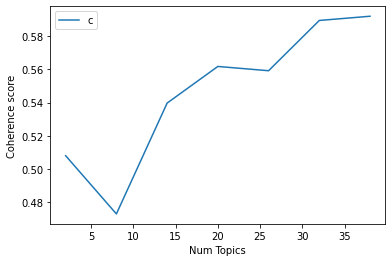

In [18]:
import matplotlib.pyplot as plt
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5079
Num Topics = 8  has Coherence Value of 0.4729
Num Topics = 14  has Coherence Value of 0.5397
Num Topics = 20  has Coherence Value of 0.5618
Num Topics = 26  has Coherence Value of 0.5592
Num Topics = 32  has Coherence Value of 0.5895
Num Topics = 38  has Coherence Value of 0.592


In [20]:

# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.060*"лопата" + 0.032*"зрозуміти" + 0.031*"камера" + 0.028*"знаити" + '
  '0.021*"виити" + 0.021*"бліно" + 0.020*"виходити" + 0.017*"заити" + '
  '0.015*"пам_ятати" + 0.014*"якраз"'),
 (1,
  '0.080*"курс" + 0.063*"привіт" + 0.056*"хтось" + 0.037*"якии" + '
  '0.025*"шукати" + 0.021*"робота" + 0.018*"проект" + 0.018*"знати" + '
  '0.018*"інформація" + 0.018*"цікаво"'),
 (2,
  '0.044*"привіт" + 0.031*"хтось" + 0.031*"хотіти" + 0.018*"якиись" + '
  '0.016*"може" + 0.016*"проходити" + 0.016*"хтсь" + 0.015*"купити" + '
  '0.013*"пивати" + 0.012*"наприклад"'),
 (3,
  '0.191*"дякувати" + 0.056*"може" + 0.029*"сказати" + 0.028*"говорити" + '
  '0.022*"піти" + 0.015*"пояснити" + 0.015*"знову" + 0.010*"серія" + '
  '0.010*"вміти" + 0.010*"подивитися"'),
 (4,
  '0.051*"приити" + 0.042*"добре" + 0.039*"першии" + 0.034*"можливо" + '
  '0.031*"тепер" + 0.027*"всі" + 0.024*"ага" + 0.023*"повідомлення" + '
  '0.018*"окоиа" + 0.018*"test"'),
 (5,
  '0.026*"діма" + 0.026*"чат" + 0.023*"мати" + 

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1363,"лопата, зрозуміти, камера, знаити, виити, блін...",зайти вебко тест камера працювати варто вихо...
1,1.0,0.3960,"курс, привіт, хтось, якии, шукати, робота, про...",відкрия glassdoor zitoune чко казати хвилин...
2,2.0,0.4217,"привіт, хтось, хотіти, якиись, може, проходити...",привіт ремонтувати місяць привіт ніхто часо...
3,3.0,0.1071,"дякувати, може, сказати, говорити, піти, поясн...",розуміти скоро актуально сказати староста ...
4,4.0,0.1268,"приити, добре, першии, можливо, тепер, всі, аг...",golang typescript will design develop test d...


In [23]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_csv(path_to_save_result_csv, index=False)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"мати, якии, хотіти, життя, розуміти, грн, вели...",292.0,0.0875
1.0,0.0,"лопата, зрозуміти, камера, знаити, виити, блін...",154.0,0.0461
2.0,0.0,"лопата, зрозуміти, камера, знаити, виити, блін...",139.0,0.0417
3.0,7.0,"інтер, написати, питання, добрии, відповідь, о...",269.0,0.0806
4.0,2.0,"привіт, хтось, хотіти, якиись, може, проходити...",200.0,0.0599
...,...,...,...,...
3332.0,4.0,"приити, добре, першии, можливо, тепер, всі, аг...",NaN,NaN
3333.0,19.0,"треба, якщо, робити, зробити, брати, щось, сит...",NaN,NaN
3334.0,5.0,"діма, чат, мати, стікер, потрібнии, нормально,...",NaN,NaN
3335.0,3.0,"дякувати, може, сказати, говорити, піти, поясн...",NaN,NaN
